In [1]:
from discrete_flow import Cell, CWComplex, compute_Flo_Hom

In [2]:
# Define the cells in the CW complex
x = Cell(0, None, "x")
y = Cell(0, None, "y")
z = Cell(1, [x, y], "z")
w = Cell(1, [x, y], "w")
t = Cell(2, [z, w], "t")
b = Cell(2, [z, w], "b")
f = Cell(3, [b, t], "f")

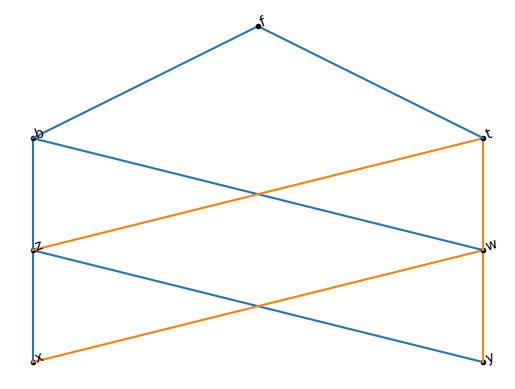

In [3]:
# Define the acyclic partial matching corresponding to our discrete Morse function
X = CWComplex([x, y, z, w, t, b, f])
mu = {
    id(y): w, # mu(y) = w
    id(z): b, # mu(z) = b
}

X.plot_lattice()

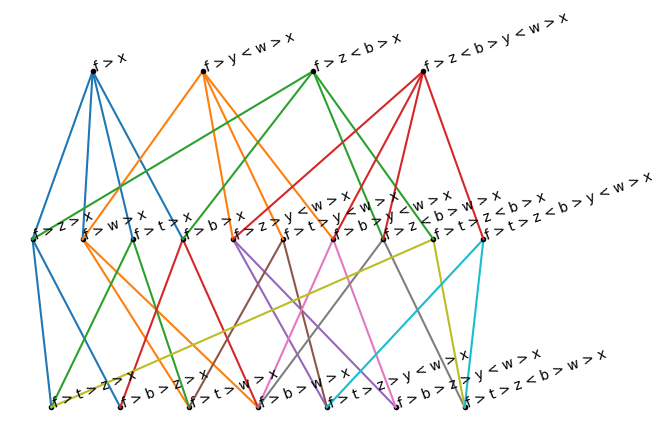

In [4]:
Hom = compute_Flo_Hom(X, mu, source=f, target=x)
Hom.plot_lattice()


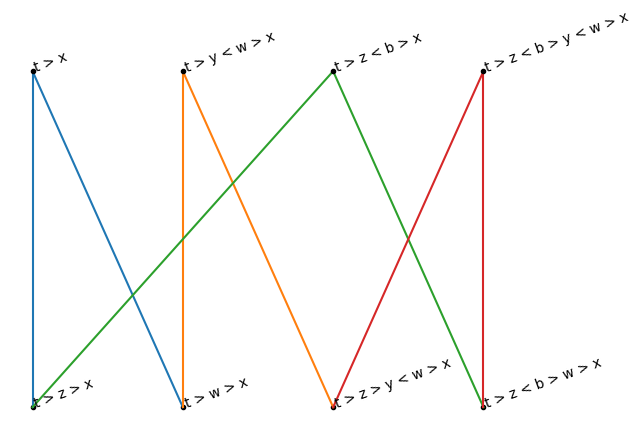

In [5]:
# This is the poset from Nanda's S^2 example
Hom = compute_Flo_Hom(X, mu, source=t, target=x)
Hom.plot_lattice()

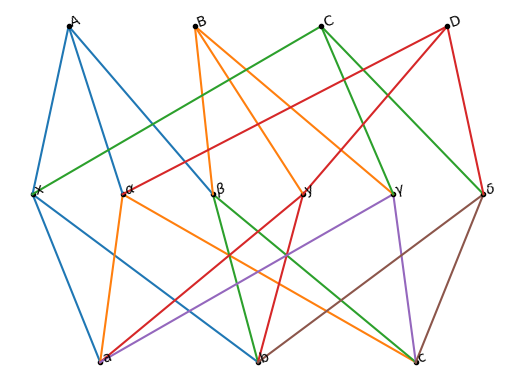

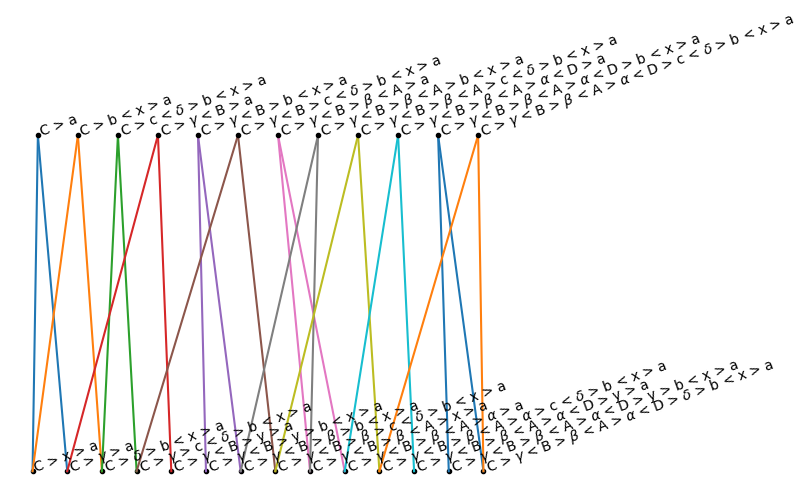

In [6]:
# My RP2 example
a = Cell(0, None, "a")
b = Cell(0, None, "b")
c = Cell(0, None, "c")
x = Cell(1, [a, b], "x")
y = Cell(1, [a, b], "y")
alpha = Cell(1, [a, c], r"$\alpha$")
gamma = Cell(1, [a, c], r"$\gamma$")
beta = Cell(1, [b, c], r"$\beta$")
delta = Cell(1, [b, c], r"$\delta$")
A = Cell(2, [x, alpha, beta], "A")
B = Cell(2, [y, beta, gamma], "B")
C = Cell(2, [x, gamma, delta], "C")
D = Cell(2, [y, alpha, delta], "D")

Y = CWComplex([a,b,c,x,y,alpha,gamma,beta,delta,A,B,C,D])
mu2 = {
    id(b): x,
    id(c): delta,
    id(alpha): D,
    id(beta): A,
    id(gamma): B,
}

Y.plot_lattice()

Hom_C_a = compute_Flo_Hom(Y, mu2, source=C, target=a)
Hom_C_a.plot_lattice()


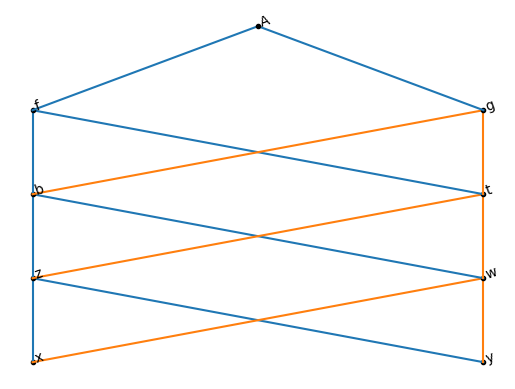

In [7]:
# Define the cells in the CW complex
x = Cell(0, None, "x")
y = Cell(0, None, "y")
z = Cell(1, [x, y], "z")
w = Cell(1, [x, y], "w")
t = Cell(2, [z, w], "t")
b = Cell(2, [z, w], "b")
f = Cell(3, [b, t], "f")
g = Cell(3, [b, t], "g")
A = Cell(4, [f, g], "A")

# Define the acyclic partial matching corresponding to our discrete Morse function
X = CWComplex([x, y, z, w, t, b, f, g, A])
mu = {
    id(y): w, # mu(y) = w
    id(b): g, # mu(z) = b
}

X.plot_lattice()

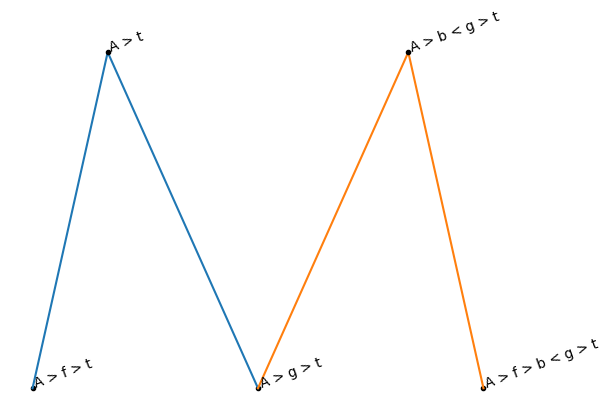

In [8]:
Hom_A_t = compute_Flo_Hom(X, mu, source=A, target=t)
Hom_A_t.plot_lattice()


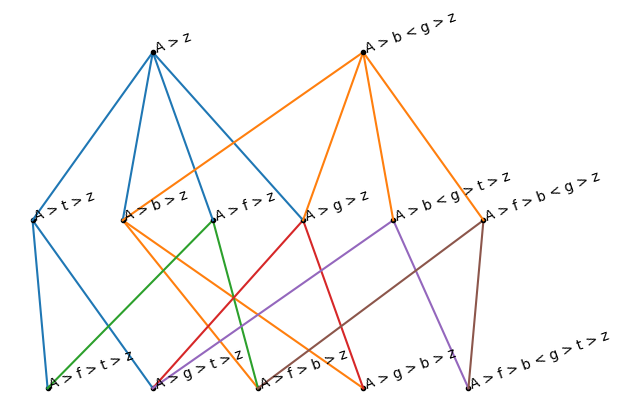

In [9]:
Hom_A_z = compute_Flo_Hom(X, mu, source=A, target=z)
Hom_A_z.plot_lattice()


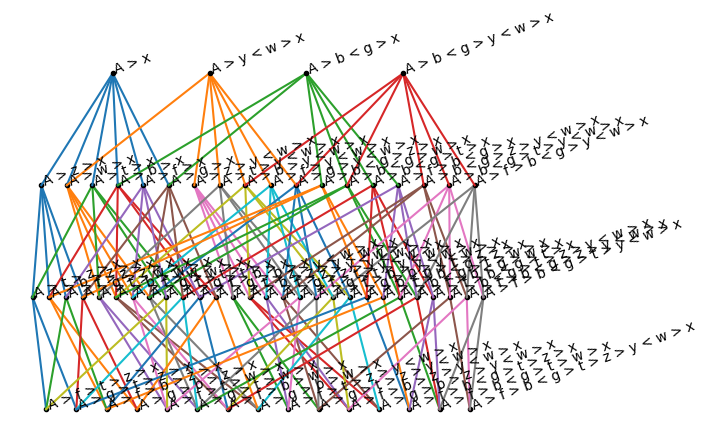

In [10]:
Hom_A_x = compute_Flo_Hom(X, mu, source=A, target=x)
Hom_A_x.plot_lattice()
